In [ ]:
### pip install plotly_express

In [1]:
import pandas as pd
import pickle
import numpy as np
from downcast import reduce
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import random 
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [48]:
pip install catboost 

RMSE Formulae

* 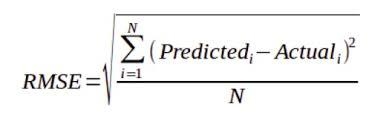

In [2]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())

In [3]:
df_sales = pd.read_csv("sales_train_evaluation.csv")

#### Loading data from the cleaned dataset

In [4]:
with open('cleaned_data.pkl','rb') as f:
   cleaned_data=pickle.load(f)

In [5]:
cleaned_data.shape

(59181090, 36)

Taking part of the dataset of day 1000 to train the dataset

In [6]:
df=cleaned_data[cleaned_data['day']>1000]

In [7]:
df.shape

(28691090, 36)

* Divide data into Train/Test/Validation 

  * Train: Till d_1885

  * Validation: From d_1886 to d_1914

  * Test: From d_1914 to d_1941

In [8]:
l=[]
for i in range(1886,1914):
  l.append(i)

x_train=df.loc[df['day']<=1885]
x_valid=df.loc[df['day'].isin(l)]
x_test=df.loc[df['day']>=1914]

y_train=x_train['demand']
y_valid=x_valid['demand']
y_test=x_test['demand']

x_train=x_train.drop(['demand'],axis=1)
x_valid=x_valid.drop(['demand'],axis=1)
x_test=x_test.drop(['demand'],axis=1)

print("x_train {}".format(x_train.shape),"  y_train {}".format(y_train.shape))
print("\nx_valid {}".format(x_valid.shape),"  y_valid {}".format(y_valid.shape))
print("\nx_test {}".format(x_test.shape),"  y_test {}".format(y_test.shape))

x_train (26983650, 35)   y_train (26983650,)

x_valid (853720, 35)   y_valid (853720,)

x_test (853720, 35)   y_test (853720,)


#### Linear Regression Model

In [12]:
lr=LinearRegression(n_jobs=-1)
lr.fit(x_train,y_train)
y_pred=lr.predict(x_valid)
print("Rmse: {}".format(rmse(y_pred,y_valid)))

Rmse: 1.8829993950614423


#### Saving into pickle

In [14]:
with open('Linear_Regression.pkl','wb') as f:
     pickle.dump(lr,f)

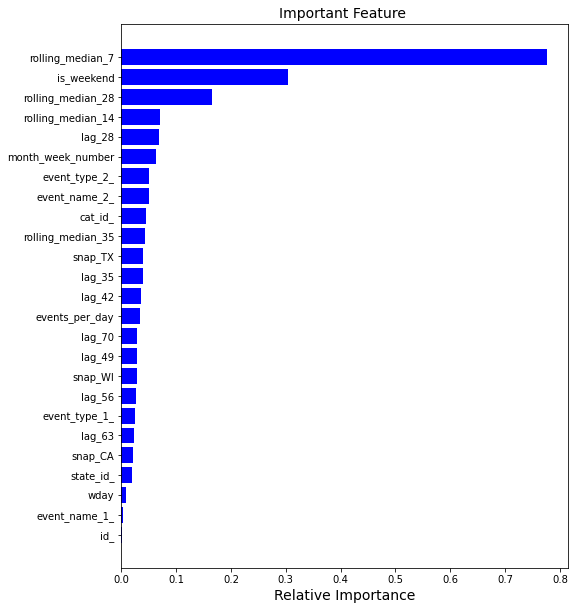

In [27]:
features=x_train.columns
imp=lr.coef_
indices=(np.argsort(imp))[10:]
plt.figure(figsize=(8,10))
plt.title('Important Feature ',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='b')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [28]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=df_sales['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=lr.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_Linear=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [51]:
submit_Linear.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.030289,0.996689,0.218460,0.170837,0.420135,0.538132,0.695572,0.332718,0.558517,...,1.941391,2.201324,2.253510,0.979218,0.360794,0.318542,0.474594,0.329437,0.588074,0.639755
1,HOBBIES_1_002_CA_1_validation,0.194595,0.125732,0.094788,0.208954,0.193268,0.453339,0.518951,0.247559,0.220261,...,0.188705,0.444565,0.551865,0.179565,0.895828,0.961792,0.947250,0.916321,0.415115,0.447021
2,HOBBIES_1_003_CA_1_validation,0.983292,1.009979,1.063187,1.115036,1.279282,1.601257,1.627197,1.230408,1.293976,...,1.104721,0.630966,0.659836,0.162506,0.107086,0.003372,0.125946,0.205383,0.300140,0.403061
3,HOBBIES_1_004_CA_1_validation,1.125870,0.822662,0.905594,2.016876,2.093658,1.820389,2.050888,2.223343,2.043060,...,1.287354,1.671753,2.219955,1.537506,1.120514,1.143890,1.154037,1.375275,2.039246,2.733551
4,HOBBIES_1_005_CA_1_validation,2.021942,1.954163,2.089996,2.033340,1.933136,1.361664,1.759277,2.059723,2.128952,...,2.285828,2.483917,2.659775,2.228928,1.421371,0.710495,0.733856,0.777359,1.706436,1.870361


In [31]:
submit_Linear.to_csv("submit_Linear.csv",index=False)

#### LGBoost 

In [32]:
for i in tqdm(range(15)):
   learning_rate=np.round(np.random.uniform(0.001,0.05),4)
   max_depth=np.random.randint(5,200)
   num_leaves=np.random.randint(20,300)
   lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
   lgb.fit(x_train,y_train)
   y_pred=lgb.predict(x_valid)
   print("\n\nlearning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))
   print("-"*150)

  7%|█████▎                                                                          | 1/15 [05:06<1:11:37, 306.93s/it]



learning_rate: 0.0304   max_depth: 35   num_leaves: 85   Rmse: 1.835137845181922
------------------------------------------------------------------------------------------------------------------------------------------------------


 13%|██████████▋                                                                     | 2/15 [10:16<1:06:49, 308.45s/it]



learning_rate: 0.014   max_depth: 88   num_leaves: 81   Rmse: 2.001804666871274
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|████████████████                                                                | 3/15 [15:08<1:00:12, 301.07s/it]



learning_rate: 0.0378   max_depth: 87   num_leaves: 95   Rmse: 1.8368946439139913
------------------------------------------------------------------------------------------------------------------------------------------------------


 27%|█████████████████████▎                                                          | 4/15 [21:29<1:00:58, 332.55s/it]



learning_rate: 0.0029   max_depth: 28   num_leaves: 272   Rmse: 2.958748267818982
------------------------------------------------------------------------------------------------------------------------------------------------------


 33%|███████████████████████████▎                                                      | 5/15 [27:09<55:51, 335.14s/it]



learning_rate: 0.0041   max_depth: 78   num_leaves: 113   Rmse: 2.763670168478532
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████████████████████████████████▊                                                 | 6/15 [31:19<45:56, 306.23s/it]



learning_rate: 0.0375   max_depth: 179   num_leaves: 28   Rmse: 1.8418917040846257
------------------------------------------------------------------------------------------------------------------------------------------------------


 47%|██████████████████████████████████████▎                                           | 7/15 [36:08<40:05, 300.73s/it]



learning_rate: 0.0486   max_depth: 17   num_leaves: 156   Rmse: 1.855640359521668
------------------------------------------------------------------------------------------------------------------------------------------------------


 53%|███████████████████████████████████████████▋                                      | 8/15 [41:57<36:51, 315.91s/it]



learning_rate: 0.0025   max_depth: 25   num_leaves: 234   Rmse: 3.0334445684917823
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|█████████████████████████████████████████████████▏                                | 9/15 [47:12<31:33, 315.66s/it]



learning_rate: 0.0412   max_depth: 196   num_leaves: 273   Rmse: 1.8413412307525001
------------------------------------------------------------------------------------------------------------------------------------------------------


 67%|██████████████████████████████████████████████████████                           | 10/15 [51:26<24:43, 296.65s/it]



learning_rate: 0.0396   max_depth: 124   num_leaves: 43   Rmse: 1.840414282856133
------------------------------------------------------------------------------------------------------------------------------------------------------


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [56:36<20:02, 300.74s/it]



learning_rate: 0.025   max_depth: 155   num_leaves: 163   Rmse: 1.8452707590677675
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [1:02:19<15:40, 313.62s/it]



learning_rate: 0.0174   max_depth: 129   num_leaves: 271   Rmse: 1.9103563235786758
------------------------------------------------------------------------------------------------------------------------------------------------------


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [1:07:57<10:41, 320.89s/it]



learning_rate: 0.0096   max_depth: 37   num_leaves: 189   Rmse: 2.192732463239911
------------------------------------------------------------------------------------------------------------------------------------------------------


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:11:58<04:56, 296.74s/it]



learning_rate: 0.0162   max_depth: 169   num_leaves: 27   Rmse: 1.9658085043123974
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:17:00<00:00, 308.00s/it]



learning_rate: 0.0081   max_depth: 110   num_leaves: 81   Rmse: 2.3116314428140274
------------------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
learning_rate=0.034 
max_depth=66 
num_leaves=224 
lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
lgb.fit(x_train,y_train)
y_pred=lgb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.034   max_depth: 66   num_leaves: 224   Rmse: 1.8310158064583975


In [34]:
with open('LGB_model.pkl','wb') as f:
     pickle.dump(lgb,f)

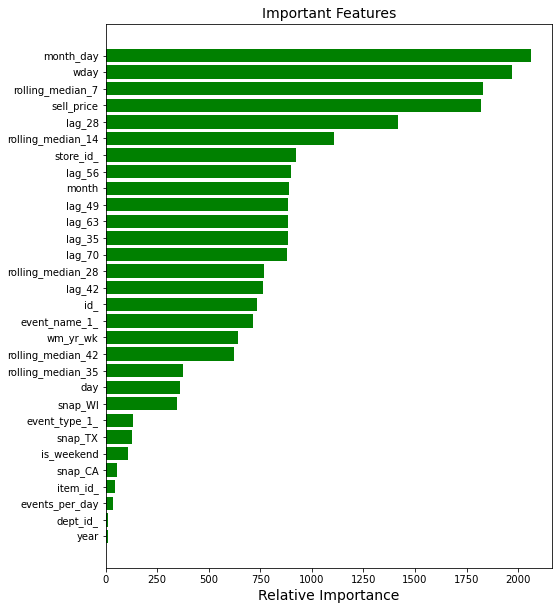

In [38]:
features=x_train.columns
imp=lgb.feature_importances_
indices=(np.argsort(imp))[5:]
plt.figure(figsize=(8,10))
plt.title('Important Features',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='g')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [41]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=df_sales['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=lgb.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_LGBM=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [42]:
submit_LGBM.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.126604,0.995363,0.614834,0.614941,0.664721,0.940508,0.934995,0.703204,0.661893,...,1.740658,2.132046,2.115631,1.046381,0.646747,0.635201,0.671481,0.908651,0.918717,0.928943
1,HOBBIES_1_002_CA_1_validation,0.276544,0.200038,0.163267,0.314738,0.229161,0.321649,0.297161,0.268746,0.164648,...,0.217357,0.276733,0.269549,0.243224,0.812395,0.813815,0.812395,0.824253,0.256858,0.230539
2,HOBBIES_1_003_CA_1_validation,0.963109,0.929192,0.934228,0.968797,0.994120,1.320046,1.265166,1.067948,1.034723,...,0.976092,0.714058,0.722603,0.516616,0.514744,0.391937,0.569048,0.591151,0.513390,0.532686
3,HOBBIES_1_004_CA_1_validation,1.248837,1.090351,1.105708,1.752837,1.831727,1.943957,2.140281,2.026690,1.940780,...,1.113010,1.503087,1.590902,1.267811,1.008208,1.038077,1.127957,1.188650,1.588529,2.334984
4,HOBBIES_1_005_CA_1_validation,1.732210,1.671026,1.739577,1.776678,1.717513,1.335772,1.813674,2.013325,1.944431,...,1.930856,2.414399,2.436942,1.955571,1.303453,1.037405,1.047265,1.120130,1.879002,1.644674


In [44]:
submit_LGBM.to_csv("submit_LGBM.csv",index=False)

####  Decision Trees 

In [10]:
for i in tqdm(range(10)): 
  max_depth=random.randint(1,200)
  min_samples_split=random.randint(10,600)
  min_samples_leaf=random.randint(20,500)
  dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
  dt.fit(x_train,y_train)
  y_pred=dt.predict(x_valid)
  print("\n\nmax_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred,y_valid)))
  print("-"*150)

 10%|████████                                                                        | 1/10 [07:02<1:03:26, 422.90s/it]



max_depth: 19   min_samples_split: 211   min_samples_leaf: 307   Rmse: 1.872287252717861
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|████████████████▍                                                                 | 2/10 [14:36<58:48, 441.04s/it]



max_depth: 157   min_samples_split: 423   min_samples_leaf: 436   Rmse: 1.8730641187489037
------------------------------------------------------------------------------------------------------------------------------------------------------


 30%|████████████████████████▌                                                         | 3/10 [21:47<50:54, 436.33s/it]



max_depth: 106   min_samples_split: 95   min_samples_leaf: 464   Rmse: 1.8778836406942812
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████████████████████████████████▊                                                 | 4/10 [29:29<44:40, 446.71s/it]



max_depth: 157   min_samples_split: 107   min_samples_leaf: 437   Rmse: 1.8777154959722093
------------------------------------------------------------------------------------------------------------------------------------------------------


 50%|█████████████████████████████████████████                                         | 5/10 [37:11<37:40, 452.11s/it]



max_depth: 104   min_samples_split: 515   min_samples_leaf: 443   Rmse: 1.869486389259562
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|█████████████████████████████████████████████████▏                                | 6/10 [43:41<28:44, 431.04s/it]



max_depth: 138   min_samples_split: 192   min_samples_leaf: 220   Rmse: 1.8740304424517094
------------------------------------------------------------------------------------------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [50:10<20:51, 417.28s/it]



max_depth: 87   min_samples_split: 109   min_samples_leaf: 221   Rmse: 1.8775095854435742
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [56:41<13:37, 408.70s/it]



max_depth: 53   min_samples_split: 54   min_samples_leaf: 222   Rmse: 1.8800247816274438
------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:03:08<06:42, 402.03s/it]



max_depth: 95   min_samples_split: 520   min_samples_leaf: 168   Rmse: 1.8763586400750916
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:09:41<00:00, 418.12s/it]



max_depth: 168   min_samples_split: 118   min_samples_leaf: 295   Rmse: 1.875206966850191
------------------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
max_depth=104
min_samples_split=278
min_samples_leaf=344 
dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
dt.fit(x_train,y_train)
y_pred=dt.predict(x_valid)
print("max_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred,y_valid)))

max_depth: 104   min_samples_split: 278   min_samples_leaf: 344   Rmse: 1.8667355819894134


In [12]:
with open('decision_tree_model.pkl','wb') as f:
     pickle.dump(dt,f)

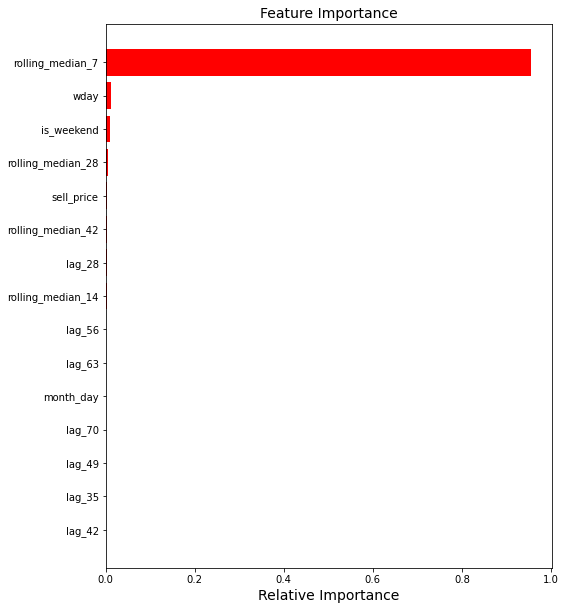

In [13]:
features=x_train.columns
imp=dt.feature_importances_
indices=(np.argsort(imp))[20:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [16]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=df_sales['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=dt.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_DecisionTree=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [18]:
submit_DecisionTree.to_csv("submit_DecisionTree.csv",index=False)

### Models RMSE Score Comparism 

* Moving Average : 3.28
* Linear Regression :1.88
* Decision Tree : 1.86
* LGBM : 1.83